In [ ]:
# %% ============================== Setup ======================================
import os
import numpy as np
import pandas as pd

# Paths
ATHLETES_CSV = "data/athletes.csv"
DAILY_CSV    = "data/daily_data.csv"
ACTIVITY_CSV = "data/activity_data.csv"

# Output filename
OUT_CSV = "bn_preprocessed.csv"

# Utility: find a "close" column name with fallback
def find_col(df, candidates, required=False):
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    if required:
        raise KeyError(f"Could not find any of {candidates} in {list(df.columns)[:20]}...")
    return None

# Utility: rolling mean by group
def grouped_rolling_mean(s, group, window, min_periods=1):
    return s.groupby(group, group_keys=False).rolling(window, min_periods=min_periods).mean().reset_index(level=0, drop=True)

# Utility: Z-score by group
def zscore_by_group(s, group):
    group_std = s.groupby(group).transform('std').replace(0, np.nan)
    group_mean = s.groupby(group).transform('mean')
    return (s - group_mean) / group_std

# Utility: Discretization
def discretize_qcut(series, q=3, labels=None):
    try:
        return pd.qcut(series, q=q, labels=labels, duplicates="drop")
    except Exception:
        return pd.Series([np.nan]*len(series), index=series.index)

# %% ======================= Loading & Normalization ======================
print("Loading data...")
ath = pd.read_csv(ATHLETES_CSV)
day = pd.read_csv(DAILY_CSV)
act = pd.read_csv(ACTIVITY_CSV)

# Standardize key ID name
ath_id_col = find_col(ath, ["athlete_id","id","user_id"], required=True)
day_id_col = find_col(day, ["athlete_id","id","user_id"], required=True)
act_id_col = find_col(act, ["athlete_id","id","user_id"], required=True)
ath = ath.rename(columns={ath_id_col:"athlete_id"})
day = day.rename(columns={day_id_col:"athlete_id"})
act = act.rename(columns={act_id_col:"athlete_id"})
ath["athlete_id"] = ath["athlete_id"].astype(str)
day["athlete_id"] = day["athlete_id"].astype(str)
act["athlete_id"] = act["athlete_id"].astype(str)

# Dates
for df_temp, name in [(day,"daily_data"), (act,"activity_data")]:
    date_col = find_col(df_temp, ["date","day","activity_date","timestamp"])
    if date_col is None:
        raise KeyError(f"A date column (e.g., 'date') is required in {name}.")
    df_temp["date"] = pd.to_datetime(df_temp[date_col]).dt.tz_localize(None)


# %% ============ Baseline Variables (from athlete.csv) ==================
# Node 1: Training_Experience
exp_col = find_col(ath, ["training_experience", "training_age","years_of_practice"], required=True)
ath["Training_Experience"] = pd.to_numeric(ath[exp_col], errors="coerce")

# Node 2: Lifestyle_Factor (Derived)
# Create an aggregated score: +Nutrition -Stress -Smoking -Drinking
nutri_col = find_col(ath, ["nutrition_factor", "nutrition"])
stress_col_base = find_col(ath, ["stress_factor", "stress"])
smoke_col = find_col(ath, ["smoking_factor", "smoking"])
drink_col = find_col(ath, ["drinking_factor", "alcohol"])
sex_col = find_col(ath, ["gender", "sex"], required=True)

ath["_lifestyle_score"] = 0.0
if nutri_col: ath["_lifestyle_score"] += pd.to_numeric(ath[nutri_col], errors='coerce').fillna(0)
if stress_col_base: ath["_lifestyle_score"] -= pd.to_numeric(ath[stress_col_base], errors='coerce').fillna(0)
if smoke_col: ath["_lifestyle_score"] -= pd.to_numeric(ath[smoke_col], errors='coerce').fillna(0)
if drink_col: ath["_lifestyle_score"] -= pd.to_numeric(ath[drink_col], errors='coerce').fillna(0)
ath["Sex"] = ath[sex_col]

# %% ============ Feature Engineering (from activity_data) ===============
print("Aggregating activity data (for Avg_Intensity)...")

# Source for Node 8: Avg_Intensity
inten_col = find_col(act, ["intensity_factor","if"], required=True)
act["_intensity"] = pd.to_numeric(act[inten_col], errors="coerce")

# Aggregate by day/athlete
daily_agg = act.groupby(["athlete_id", "date"], as_index=False).agg(
    Avg_Intensity = ("_intensity", "mean") # Node 8
)

# %% ================== Merge & Daily Data ======================
print("Merging data...")
df = pd.merge(day, daily_agg, on=["athlete_id", "date"], how="outer")
df = pd.merge(df, ath, on="athlete_id", how="left", suffixes=("_day", "_ath"))
df = df.sort_values(["athlete_id", "date"]).reset_index(drop=True)

# %% =================== Feature Engineering (Post-Merge) ===================
print("Calculating derived features...")

# --- Daily Load & Wellness ---
sleep_q_col = find_col(df, ["sleep_quality_day", "sleep_quality","sleep_score"], required=True)
hrv_col = find_col(df, ["hrv", "hrv_ms","rmssd_ms","hrv_morning"], required=True)
stress_col_day = find_col(df, ["stress_day", "stress","stress_score"], required=True)
load_col = find_col(df, ["actual_tss", "tss"], required=True)
inj_col = find_col(df, ["injury","injured"], required=True)

df["Sleep_Quality"] = pd.to_numeric(df[sleep_q_col], errors="coerce")
df["Morning_HRV"]   = pd.to_numeric(df[hrv_col], errors="coerce")
df["Daily_Stress"]  = pd.to_numeric(df[stress_col_day], errors="coerce")
df["Training_Load"] = pd.to_numeric(df[load_col], errors="coerce")
df["Injury_Risk"]   = pd.to_numeric(df[inj_col], errors="coerce").fillna(0).clip(0,1).astype(int)

# --- Static Baseline Factors (Age, BMI, Sex) ---
age_col = find_col(df, ["age_ath", "age"], required=True) 
df["Age"] = pd.to_numeric(df[age_col], errors="coerce")
sex_col_final = find_col(df, ["Sex_ath", "Sex", "gender_ath"], required=True)
df["Sex_Source"] = df[sex_col_final]
h_col = find_col(df, ["height_cm_ath","height_cm"], required=True)
w_col = find_col(df, ["weight_kg_ath","weight_kg"], required=True)
df["height_m"] = pd.to_numeric(df[h_col], errors="coerce") / 100.0
df["weight_kg"] = pd.to_numeric(df[w_col], errors="coerce")
df["BMI"] = df["weight_kg"] / (df["height_m"]**2)


# Fill 0 for rest days (IMPORTANT: do this before rolling means)
df["Training_Load"] = df["Training_Load"].fillna(0.0)

# Node 9: Acute_Chronic_Ratio
df["_load_7d_mean"] = grouped_rolling_mean(df["Training_Load"], df["athlete_id"], 7)
df["_load_28d_mean"]= grouped_rolling_mean(df["Training_Load"], df["athlete_id"], 28)
df["Acute_Chronic_Ratio"] = df["_load_7d_mean"] / df["_load_28d_mean"]
df["Acute_Chronic_Ratio"] = df["Acute_Chronic_Ratio"].replace([np.inf, -np.inf], np.nan)

# Node 6: Ready_To_Train (Composite Z-score)
z_sleep = zscore_by_group(df["Sleep_Quality"], df["athlete_id"])
z_hrv = zscore_by_group(df["Morning_HRV"], df["athlete_id"])
z_stress = zscore_by_group(df["Daily_Stress"], df["athlete_id"])
df["_ready_score"] = z_sleep.fillna(0) + z_hrv.fillna(0) - z_stress.fillna(0)


# --- INJURY PREDICTORS (NEW CRUCIAL NODES) ---
# Node 11: Injury_Prev30d (Rolling max on 30 days, shifted by 1)
df["Injury_Prev30d"] = (df
    .groupby("athlete_id")["Injury_Risk"]
    .rolling(30, min_periods=1).max()
    .reset_index(level=0, drop=True)
).shift(1).fillna(0).astype(int)

# Node 12: Injury_History_12m (Rolling sum on 365 days, shifted by 1)
hist_365 = (df
    .groupby("athlete_id")["Injury_Risk"]
    .rolling(365, min_periods=1).sum()
    .reset_index(level=0, drop=True)
).shift(1).fillna(0)


# %% ======================== Discretization =============================
print("Discretizing all 15 variables...")
df_out = pd.DataFrame()
df_out["athlete_id"] = df["athlete_id"]
df_out["date"] = df["date"]

# --- Long-Term Factors (5 Nodes) ---
df_out["Training_Experience"] = discretize_qcut(df["Training_Experience"], q=3, labels=["Low", "Medium", "High"])
df_out["Lifestyle_Factor"] = discretize_qcut(df["_lifestyle_score"], q=3, labels=["Negative", "Neutral", "Positive"])
df_out["Age_d"] = pd.cut(df["Age"], 
                         bins=[-np.inf, 25, 35, np.inf], 
                         labels=["Young (<25)", "Adult (25-35)", "Veteran (>35)"])
df_out["BMI_d"] = pd.cut(df["BMI"], 
                         bins=[0, 18.5, 25, 30, np.inf], 
                         labels=["Underweight", "Normal", "Overweight", "Obese"])
df_out["Sex_d"] = df["Sex_Source"].astype(str).str.lower().map(
    {'male': 'Male', 'female': 'Female'}
).fillna('Missing').astype('category')


# --- Dynamic Predictors (5 Nodes) ---
df_out["Sleep_Quality"] = discretize_qcut(df["Sleep_Quality"], q=3, labels=["Poor", "Good", "Great"])
df_out["Morning_HRV"] = discretize_qcut(z_hrv, q=3, labels=["Low", "Normal", "High"])
df_out["Daily_Stress"] = discretize_qcut(df["Daily_Stress"], q=3, labels=["Low", "Medium", "High"])
df_out["Avg_Intensity"] = discretize_qcut(df["Avg_Intensity"], q=3, labels=["Low", "Medium", "High"])
df_out["Training_Load"] = discretize_qcut(df["Training_Load"].replace(0, np.nan), q=3, labels=["Low", "Medium", "High"])

# --- Hubs and History (4 Nodes) ---
df_out["Ready_To_Train"] = discretize_qcut(df["_ready_score"], q=2, labels=["No", "Yes"])
df_out["Acute_Chronic_Ratio"] = "Low (Good)" 
df_out.loc[(df['Acute_Chronic_Ratio'] < 0.8) | (df['Acute_Chronic_Ratio'] > 1.3), 'Acute_Chronic_Ratio'] = 'Risk (High)'
df_out.loc[df['Acute_Chronic_Ratio'].isna(), 'Acute_Chronic_Ratio'] = np.nan 

# INJURY HISTORY NODES --- LOGIC FIX FOR IMBALANCE (using quantiles for optimal split) ---
# We use qcut/quantile-based bins to find the optimal thresholds for homogeneous grouping.
# This ensures that the risk tiers (Low, Medium, High) are evenly sized in the dataset.

# Calculate Quantile Bins for 3 equal frequency groups (Optimal Homogeneous Discretization)
q_bins = hist_365.quantile([0.0, 0.333, 0.666, 1.0]).unique().tolist()
# Ensure the first bin starts below the minimum possible value (0)
if q_bins[0] > -0.1:
    q_bins[0] = -0.1 

print(f"Injury_History_12m quantile bins: {q_bins}")

# If only 2 unique bins are returned (due to large clusters at 0 or other values), 
# use only 2 labels.
q_labels = ["Low Risk", "Medium Risk", "High Risk"] 

# Use pd.cut with the calculated quantile bins
df_out["Injury_History_12m"] = pd.cut(hist_365, 
                                 bins=q_bins,
                                 labels=q_labels[:len(q_bins)-1],
                                 include_lowest=True,
                                 duplicates='drop').astype('category')

# NEW INJURY HISTORY NODES
df_out["Injury_Prev30d"] = df["Injury_Prev30d"].map({0: "No", 1: "Yes"}).astype('category')


# --- Outcome (1 Node) ---
df_out["Injury_Risk"] = df["Injury_Risk"].map({0: "No", 1: "Yes"})


# %% ==================== NaN Handling for BN =====================
# Discrete Bayesian networks do not handle NaNs.
# We convert NaNs to an explicit "Missing" category.

discrete_cols = [
    "Training_Experience", "Lifestyle_Factor", 
    "Age_d", "BMI_d", "Sex_d", 
    "Sleep_Quality", "Morning_HRV", "Daily_Stress",
    "Avg_Intensity", "Training_Load", # Dynamic Inputs
    "Ready_To_Train", "Acute_Chronic_Ratio", 
    "Injury_Prev30d", "Injury_History_12m", # INJURY HISTORY/RECENT NODES
    "Injury_Risk"
]

print("Converting NaNs to 'Missing' for all 15 discrete variables...")
for col in discrete_cols:
    if col not in df_out.columns:
        print(f"Warning: Column {col} not found for fillna.")
        continue
    
    if not pd.api.types.is_categorical_dtype(df_out[col]):
         df_out[col] = df_out[col].astype('category')
    
    if df_out[col].isnull().any():
        if "Missing" not in df_out[col].cat.categories:
            df_out[col] = df_out[col].cat.add_categories("Missing")
        df_out[col] = df_out[col].fillna("Missing")

# %% ============================== Export ====================================
cols_keep = [
    "athlete_id", "date",
    "Training_Experience", "Lifestyle_Factor", 
    "Age_d", "BMI_d", "Sex_d", 
    "Sleep_Quality", "Morning_HRV", "Daily_Stress", 
    "Avg_Intensity", "Training_Load", 
    "Ready_To_Train", "Acute_Chronic_Ratio",
    "Injury_Prev30d", "Injury_History_12m", # ADDED
    "Injury_Risk"
]

# Keep only the columns that actually exist
cols_keep_final = [c for c in cols_keep if c in df_out.columns]
df_final = df_out[cols_keep_final].copy()

df_final.to_csv(OUT_CSV, index=False)
print(f"\nSaved: {OUT_CSV} — rows: {len(df_final):,}")
print(f"Generated columns (15 total): {list(df_final.columns)[2:]}")

# Final step: Execute

Loading data...
Aggregating activity data (for Avg_Intensity)...
Merging data...
Calculating derived features...
Discretizing all 15 variables...
Injury_History_12m quantile bins: [-0.1, 6.0, 18.0, 78.0]
Converting NaNs to 'Missing' for all 15 discrete variables...


/var/folders/c8/k22vp0k173j11cvw1ytbyp080000gn/T/ipykernel_24459/95414711.py:250: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_out[col]):
/var/folders/c8/k22vp0k173j11cvw1ytbyp080000gn/T/ipykernel_24459/95414711.py:250: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_out[col]):



Saved: bn_preprocessed_v7_optimal.csv — rows: 366,000
Generated columns (15 total): ['Training_Experience', 'Lifestyle_Factor', 'Age_d', 'BMI_d', 'Sex_d', 'Sleep_Quality', 'Morning_HRV', 'Daily_Stress', 'Avg_Intensity', 'Training_Load', 'Ready_To_Train', 'Acute_Chronic_Ratio', 'Injury_Prev30d', 'Injury_History_12m', 'Injury_Risk']


In [36]:
df_final.value_counts("Injury_History_12m")

Injury_History_12m
Low Risk       130695
Medium Risk    118016
High Risk      117289
Name: count, dtype: int64

Generazione del grafo causale finale (15 nodi)...


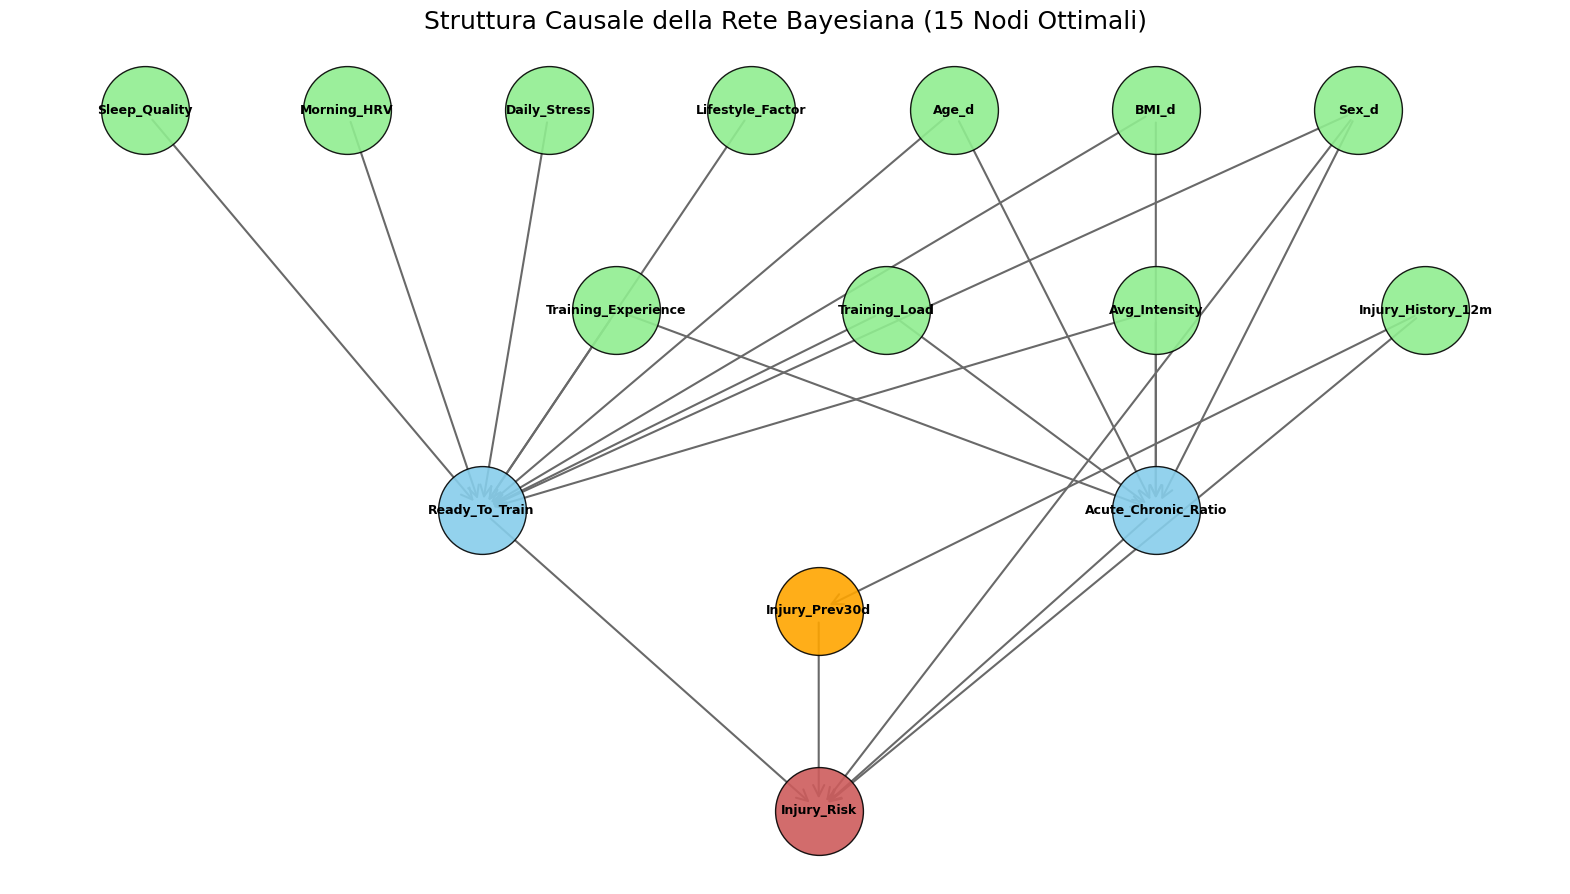


Il grafico finale con 15 nodi (inclusi i predittori storici e demografici) è stato generato.


In [37]:
# %% ========================== Visualizzazione Grafo Finale (15 Nodi Ottimali) =============================
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork

# 1. Definizione della Struttura Causale (15 Nodi Ottimali)
BN_STRUCTURE = [
    # --- FATTORI STATICI E STORICI (Root Nodes) ---
    ('Sex_d', 'Ready_To_Train'), ('Sex_d', 'Acute_Chronic_Ratio'), ('Sex_d', 'Injury_Risk'),           
    ('Age_d', 'Ready_To_Train'), ('Age_d', 'Acute_Chronic_Ratio'),   
    ('BMI_d', 'Ready_To_Train'), ('BMI_d', 'Acute_Chronic_Ratio'),
    ('Lifestyle_Factor', 'Ready_To_Train'),
    ('Training_Experience', 'Ready_To_Train'), ('Training_Experience', 'Acute_Chronic_Ratio'),
    ('Injury_History_12m', 'Injury_Prev30d'), ('Injury_History_12m', 'Injury_Risk'),
    
    # --- FATTORI DINAMICI (Input diretti) -> Hubs ---
    ('Sleep_Quality', 'Ready_To_Train'),
    ('Morning_HRV', 'Ready_To_Train'),
    ('Daily_Stress', 'Ready_To_Train'),
    ('Training_Load', 'Acute_Chronic_Ratio'),
    ('Training_Load', 'Ready_To_Train'), 
    ('Avg_Intensity', 'Acute_Chronic_Ratio'),
    ('Avg_Intensity', 'Ready_To_Train'),

    # --- HUBs e STATO RECENTE -> TARGET ---
    ('Ready_To_Train', 'Injury_Risk'),
    ('Acute_Chronic_Ratio', 'Injury_Risk'),
    ('Injury_Prev30d', 'Injury_Risk'), # NUOVO
]

# 2. Crea il modello pgmpy
injury_risk_model = DiscreteBayesianNetwork(BN_STRUCTURE)

# 3. DEFINIZIONE MANUALE DEL LAYOUT GERARCHICO (15 Nodi)
# Assegna coordinate (x, y) per stratificare i 3 livelli (Input, Hubs, Target)
pos = {
    # --- Livello 3 (Target: Y=0) ---
    'Injury_Risk': (0, 0),

    # --- Livello 2 (Hubs & Stato Recente: Y=1.5 e Y=1.0) ---
    'Ready_To_Train': (-2.5, 1.5),
    'Acute_Chronic_Ratio': (2.5, 1.5),
    'Injury_Prev30d': (0, 1.0), # Storia recente, sotto gli hub principali

    # --- Livello 1 (Input/Root Nodes: Y=3.5 e Y=2.5) ---
    # 10 nodi di input stratificati:
    # Gruppo Wellness/Statici (Y=3.5):
    'Sleep_Quality': (-5, 3.5),
    'Morning_HRV': (-3.5, 3.5),
    'Daily_Stress': (-2, 3.5),
    'Lifestyle_Factor': (-0.5, 3.5),
    'Age_d': (1, 3.5),
    'BMI_d': (2.5, 3.5),
    'Sex_d': (4, 3.5),
    
    # Gruppo Load/History (Y=2.5):
    'Training_Experience': (-1.5, 2.5),
    'Training_Load': (0.5, 2.5),
    'Avg_Intensity': (2.5, 2.5),
    'Injury_History_12m': (4.5, 2.5),
}

# 4. GENERAZIONE E STAMPA DEL GRAFO
print("Generazione del grafo causale finale (15 nodi)...")

graph = nx.DiGraph(injury_risk_model.edges())

# Identifica i nodi per la colorazione
hub_and_target_nodes = ['Injury_Risk', 'Ready_To_Train', 'Acute_Chronic_Ratio', 'Injury_Prev30d']
target_node = ['Injury_Risk']
recent_history_node = ['Injury_Prev30d']
hub_nodes = ['Ready_To_Train', 'Acute_Chronic_Ratio']
root_nodes = [n for n in graph.nodes if n not in hub_and_target_nodes]


plt.figure(figsize=(20, 11)) 
plt.title("Struttura Causale della Rete Bayesiana (15 Nodi Ottimali)", fontsize=18)

# Disegna i nodi (colorati per livello)
nx.draw_networkx_nodes(
    graph, pos, 
    nodelist=target_node, 
    node_size=4000, node_color='indianred', edgecolors='black', alpha=0.9 # TARGET
)
nx.draw_networkx_nodes(
    graph, pos, 
    nodelist=hub_nodes, 
    node_size=4000, node_color='skyblue', edgecolors='black', alpha=0.9 # HUBS
)
nx.draw_networkx_nodes(
    graph, pos, 
    nodelist=recent_history_node,
    node_size=4000, node_color='orange', edgecolors='black', alpha=0.9 # RECENT HISTORY
)
nx.draw_networkx_nodes(
    graph, pos, 
    nodelist=root_nodes,
    node_size=4000, node_color='lightgreen', edgecolors='black', alpha=0.9 # INPUTS
)

# Disegna le etichette dei nodi
nx.draw_networkx_labels(
    graph, pos, 
    font_size=9, 
    font_weight='bold', 
    font_color='black'
)

# Disegna gli archi
nx.draw_networkx_edges(
    graph, pos, 
    arrowstyle='->', 
    arrowsize=20, 
    edge_color='dimgray', 
    width=1.5
)

plt.axis('off') 
plt.show()
print("\nIl grafico finale con 15 nodi (inclusi i predittori storici e demografici) è stato generato.")


## 📋 Tabella: Nodi della Rete Bayesiana (15 Variabili Ottimali)

| Variabile (Nodo) | Categoria/Ruolo | Perché è importante (Ruolo Causale) | Come viene calcolata (Feature Engineering) |
| :--- | :--- | :--- | :--- |
| **Fattori Statici (5)** | | | |
| **`Training_Experience`** | BASELINE (Esperienza) | Indica la **resilienza strutturale** e la capacità di tollerare il volume di allenamento. | `training_experience` (da `athletes.csv`) discretizzata in **Terzili** (`Low`/`Medium`/`High`). |
| **`Age_d`** | BASELINE (Demografico) | Fattore di rischio demografico; la capacità di recupero diminuisce con l'età. | `age` (da `athletes.csv`) discretizzata in **Fasce d'età** (`Young/<25`, `Adult/25-35`, `Veteran/>35`). |
| **`BMI_d`** | BASELINE (Fisico) | Rischio strutturale e metabolico. Un peso non ottimale è un predittore di infortuni. | Calcolato come **BMI** (`weight_kg` / `height_m`²) e discretizzato in **Soglie cliniche standard** (`Underweight`, `Normal`, `Overweight`, `Obese`). |
| **`Sex_d`** | BASELINE (Biologico) | **Fattore Biologico primario** che influenza i profili di infortunio e la risposta al carico. | `gender` (da `athletes.csv`) mappata a **`Male`** / **`Female`**. |
| **`Lifestyle_Factor`** | LIFESTYLE | Aggrega il rischio di base non legato all'allenamento (nutrizione, stress cronico, fumo/alcol). | Punteggio numerico **aggregato** (Somma ponderata dei fattori numerici di `athletes.csv`), discretizzato in **Terzili** (`Negative`/`Neutral`/`Positive`). |
| **Fattori Dinamici (5)** | | | |
| **`Sleep_Quality`** | INPUT RECUPERO | Misura soggettiva del recupero mentale e fisico. Input primario per la prontezza. | `sleep_quality` (da `daily_data.csv`) discretizzata in **Terzili** (`Poor`/`Good`/`Great`). |
| **`Morning_HRV`** | INPUT RECUPERO | Indicatore fisiologico del bilancio simpatico/parasimpatico (stress vs. recupero). | `hrv` (da `daily_data.csv`) normalizzato con **Z-score per atleta**, discretizzato in **Terzili** (`Low`/`Normal`/`High`). |
| **`Daily_Stress`** | INPUT RECUPERO | Livello di stress percepito (lavoro, vita). Influisce direttamente sulla capacità di recupero. | `stress` (da `daily_data.csv`) discretizzato in **Terzili** (`Low`/`Medium`/`High`). |
| **`Training_Load`** | INPUT CARICO | Quantità assoluta di stress di allenamento somministrato nel giorno (TSS). | `actual_tss` (da `daily_data.csv`). I giorni di riposo sono mappati a **`Missing`**. |
| **`Avg_Intensity`** | INPUT CARICO | Qualità o intensità dello stress somministrato durante il training. | **Media** di `intensity_factor` (IF) da `activity_data.csv` (aggregata per giorno) discretizzata in **Terzili** (`Low`/`Medium`/`High`). |
| **Hubs e Target (5)** | | | |
| **`Ready_To_Train`** | HUB RECUPERO | **Prontezza Funzionale.** Nodo composito che aggrega lo stato di recupero interno. | **Z-score Composto:** (`Z_Sleep` + `Z_HRV` - `Z_Stress`) discretizzato in **Mediana** (`No`/`Yes`). |
| **`Acute_Chronic_Ratio`**| HUB CARICO | **Tolleranza al Carico.** Misura la discrepanza tra carico acuto (7 giorni) e capacità cronica (28 giorni). | **Media Mobile:** `Load_7d_Mean / Load_28d_Mean`. Discretizzato in **Soglie** (`Low (Good)` se [0.8-1.3], altrimenti `Risk (High)`). |
| **`Injury_Prev30d`** | STATO RECENTE | **Rischio Immediato.** Flag che indica un infortunio nel mese precedente. | **Rolling Max:** Valore massimo di infortunio (0/1) nei **30 giorni precedenti** (con `shift`), mappato a (`No`/`Yes`). |
| **`Injury_History_12m`** | STORIA CRONICA | **Rischio Storico.** Frequenza degli infortuni in un anno. Il predittore più potente in assoluto. | **Rolling Sum:** Conteggio totale degli infortuni nei **365 giorni precedenti** (con `shift`), discretizzato in (`0`, `1`, `2+`). |
| **`Injury_Risk`** | TARGET | L'obiettivo binario da predire: **rischio di infortunio nel giorno corrente**. | `injury` (da `daily_data.csv`) mappato a **`No` (0)** o **`Yes` (1)**. |

---